# Heim & Kratzer Chapter 5

This notebook demonstrates the Heim & Kratzer (1998) Chapter 5 semantic rules using a toy lexicon, the `Interpreter` class, and the ultra-light backtick DSL for `PhiValue` literals.

## Import Required Libraries

Import all necessary modules, including `Interpreter`, `Tree`, `PhiValue`, and the backtick DSL installer.

In [1]:
from phosphorus.semantics.interpret import Interpreter, defined
from phosphorus.syntax.tree import Tree
from phosphorus.core.phivalue import PhiValue
from phosphorus.core.stypes import Type, takes
from phosphorus.core.constants import UNDEF, VACUOUS

# Install the backtick DSL for PhiValue literals
import phosphorus.dsl.backtick

# Configure IPython to display all outputs in a cell
%config InteractiveShell.ast_node_interactivity='all'


             _    _                  _    _
            | |  | |                | |  | |
           _| |_ | |__   ___  ___  _| |_ | |__   ___  _ __ _   _  ____
          /     \| '_ \ / _ \/ __|/     \| '_ \ / _ \| '__| | | |/ ___)
         ( (| |) ) | | | (_) \__ ( (| |) ) | | | (_) | |  | |_| ( (__
          \_   _/|_| |_|\___/|___/\_   _/|_| |_|\___/|_|   \__,_|\__ \
            | |                     | |                            _) )
            |_|                     |_|                           (__/

        Welcome to the Phosphorus Meaning Engine v3
        Created by Ezra Keshet (EzraKeshet.com)




## Define Lexicon

Create a dictionary mapping lexical items (e.g., 'john', 'mary', 'runs', 'loves') to their `PhiValue` representations using the backtick DSL.

In [2]:
lexicon = {
  "john"  : `JOHN.e,
  "mary"  : `MARY.e,
  "cat"   : `lambda x=e: CAT(x).t,
  "gray"  : `lambda x=e: GRAY(x).t,
  "runs"  : `lambda x=e: RUN(x).t,
  "loves" : `lambda y=e: (lambda x=e: LOVE(x,y).t),
  "the"   : `lambda f=et: iota(f).e % singular(f),
}

## Create Interpreter and Register Rules

Instantiate an `Interpreter` named `interpret5a`, assign the lexicon, and define the TN, NN, FA, and PM rules.

In [3]:
interpret5a = Interpreter(lexicon=lexicon)

# Trace and Pronouns (TP): return the assignment a
@interpret5a.rule()
def TP(*, alpha: str):
  """Trace and Pronouns: return the assignment a."""
  if alpha not in {"he", "she", "it", "they", "them", "him", "her", "t"}:
    return UNDEF
  return `a.e

# Predicate Abstraction (PA): bind the assignment a
@interpret5a.rule()
def PA(beta: PhiValue, *, alpha: str):
  """Predicate Abstraction: bind the assignment a."""
  if alpha[0] not in {"who", "that", "which"}:
    return UNDEF
  if beta.stype == Type.t:
    return `lambda x=e: beta(a=x).t
  return UNDEF

# Terminal Node (TN): lexical lookup
@interpret5a.rule()
def TN(*, alpha: str):    
  """Terminal Node: lexical lookup of *alpha* (string token)."""
  return interpret5a.lookup(alpha)

# Non-Branching Node (NN): pass child meaning unchanged
@interpret5a.rule()
def NN(beta: PhiValue):
  """Non-branching Node: pass child meaning unchanged."""
  return beta

# Functional Application (FA): apply function to argument
@interpret5a.rule()
def FA(beta: PhiValue, gamma: PhiValue):
  """Functional Application (order determined by `takes`)."""
  if UNDEF in (beta, gamma):
    return UNDEF

  if takes(beta, gamma):
    fn, arg = beta, gamma
  elif takes(gamma, beta):
    fn, arg = gamma, beta
  else:
    return UNDEF

  return `fn(arg) % defined(arg) # Note that if arg fails the fn guard, it will already return UNDEF

# Predicate Modification (PM): conjoin meanings
@interpret5a.rule()
def PM(beta: PhiValue, gamma: PhiValue):
  """Predicate Modification: conjoin meanings."""
  if UNDEF in (beta, gamma):
    return UNDEF
  
  if beta.stype == gamma.stype == Type.et:
    return `lambda x=e: beta(x) and gamma(x) % defined(beta(x)) % defined(gamma(x))

  return UNDEF

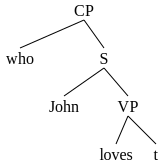

lambda x: LOVE(JOHN, x)

CP -> lambda x: LOVE(JOHN, x)
who -> who
S -> LOVE(JOHN, a)
John -> John
VP -> lambda x: LOVE(x, a)
loves -> loves
t -> t


In [4]:
t1 = Tree.fromstring(
'''
(CP who
  (S John
    (VP loves t)
  )
)
''')

t1
m1 = interpret5a.interpret(t1)
m1

# Print out x.sem recursively for each subtree x in t1
def print_semantics(t):
  if isinstance(t, Tree):
    print(f"{t.label()} -> {t.sem}")
    for child in t:
      print_semantics(child)
  else:
    print(f"{t} -> {t}")
print_semantics(t1)

In [5]:
interpret5b = Interpreter(lexicon=lexicon)

# Trace and Pronouns (TP): return the assignment a
@interpret5b.rule()
def TP(*, alpha: str):
  """Trace and Pronouns: return the assignment a."""
  try:
    i = int(alpha.split('_')[1])
    return `g[i].e
  except: pass
  
  return UNDEF

# Predicate Abstraction (PA): bind the assignment a
@interpret5b.rule()
def PA(beta: PhiValue, *, alpha: str):
  """Predicate Abstraction: bind the assignment a."""
  try:
    i = int(alpha[0])
    if beta.stype == Type.t:
      return `lambda x=e: beta(g=g|{i:x}).t
  except: pass
  
  return UNDEF

# Terminal Node (TN): lexical lookup
@interpret5b.rule()
def TN(*, alpha: str):    
  """Terminal Node: lexical lookup of *alpha* (string token)."""
  return interpret5b.lookup(alpha)

# Non-Branching Node (NN): pass child meaning unchanged
@interpret5b.rule()
def NN(beta: PhiValue):
  """Non-branching Node: pass child meaning unchanged."""
  return beta

# Functional Application (FA): apply function to argument
@interpret5b.rule()
def FA(beta: PhiValue, gamma: PhiValue):
  """Functional Application (order determined by `takes`)."""
  if UNDEF in (beta, gamma):
    return UNDEF

  if takes(beta, gamma):
    fn, arg = beta, gamma
  elif takes(gamma, beta):
    fn, arg = gamma, beta
  else:
    return UNDEF

  return `fn(arg) % defined(arg) # Note that if arg fails the fn guard, it will already return UNDEF

# Predicate Modification (PM): conjoin meanings
@interpret5b.rule()
def PM(beta: PhiValue, gamma: PhiValue):
  """Predicate Modification: conjoin meanings."""
  if UNDEF in (beta, gamma):
    return UNDEF
  
  if beta.stype == gamma.stype == Type.et:
    return `lambda x=e: beta(x) and gamma(x) % defined(beta(x)) % defined(gamma(x))

  return UNDEF

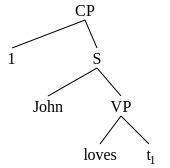

lambda x: LOVE(JOHN, x)

CP -> lambda x: LOVE(JOHN, x)
1 -> 1
S -> LOVE(JOHN, g[1])
John -> John
VP -> lambda x: LOVE(x, g[1])
loves -> loves
t_1 -> t_1


In [6]:
t1 = Tree.fromstring(
'''
(CP 1
  (S John
    (VP loves t_1)
  )
)
''')

t1
m1 = interpret5b.interpret(t1)
m1

# Print out x.sem recursively for each subtree x in t1
def print_semantics(t):
  if isinstance(t, Tree):
    print(f"{t.label()} -> {t.sem}")
    for child in t:
      print_semantics(child)
  else:
    print(f"{t} -> {t}")
print_semantics(t1)

## Test Example Sentences

Parse and interpret example syntactic trees using `interpret4`, displaying both the tree and its semantic interpretation.

In [7]:
examples = [
  '(NP gray cat)',
  '(NP the cat)',
  '(S (NP the cat) (VP runs))',
  '(S (NP the cat) (VP (V loves) (NP Mary)))',
  '(DP the (NP gray cat))',
  '(S (DP the (NP gray cat)) (VP (V loves) (DP Mary)))',
]

In [8]:
from IPython.display import display, HTML

for src in examples:
  tree = Tree.fromstring(src)
  meaning = interpret4.interpret(tree)
  tree_html = tree._repr_svg_()  # SVG as HTML string
  meaning_html = meaning._repr_html_()  # HTML as string
  display(HTML(f"""
    <table>
      <tr>
        <td style="vertical-align:top;min-width:18ch;text-align:left">{tree_html}</td>
        <td style="vertical-align:top;padding-left:2em">{meaning_html}</td>
      </tr>
    </table>
  """))

NameError: name 'interpret4' is not defined

In [ ]:
DOMAIN = [PhiValue(x, stype=Type.e) for x in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ']  # Example domain of entities
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z = DOMAIN

def singular(f: PhiValue) -> bool:
  """Check if the predicate f is singular."""
  if f.stype != Type.et:
    return False
  # A predicate is singular if it returns True for exactly one entity
  count = sum(1 for x in DOMAIN if f(x))
  return count == 1

def CAT(x): 
  return x == PhiValue('A')

CAT(A), CAT(B)
lexicon["cat"](A), lexicon["cat"](B)

f'{singular(lexicon["cat"])=}'


(True, False)

(True, False)

'singular (lexicon ["cat"])=True'